In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
# for avoiding warnings
import warnings
warnings.filterwarnings('ignore')

## The Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 17 fields.

In [2]:
data = pd.read_csv('data/bank-full.csv',  sep=';',header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(45211, 17)
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


#### Input variables

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric)

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

#### Predict variable (desired target):

y - has the client subscribed a term deposit? (binary: '1','0')

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [4]:
data['education'].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

educations are "tertiary", "secondary" and "unknown"

### Data exploration

In [5]:
data['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

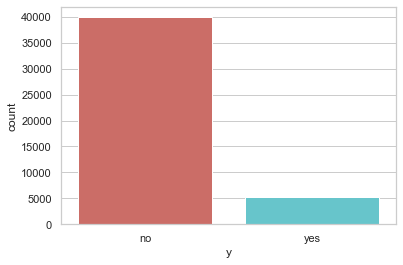

In [6]:
sns.countplot(x='y',data=data, palette='hls')
plt.show()

In [7]:
count_no_sub = len(data[data['y']=="no"])
count_sub = len(data[data['y']=="yes"])
print(count_no_sub+count_sub)
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)

pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

45211
percentage of no subscription is 88.30151954170445
percentage of subscription 11.698480458295547


Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 89:11. Before we go ahead to balance the classes, Let's do some more exploration.

In [8]:
data.groupby('y').mean()

,age,balance,day,duration,campaign,pdays,previous
y,,,,,,,
no,40.838986,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154
yes,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354


Observations:

The average age of customers who bought the term deposit is higher than that of the customers who didn't. The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale. Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [9]:
data.groupby('job').mean()

,age,balance,day,duration,campaign,pdays,previous
job,,,,,,,
admin.,39.289886,1135.838909,15.564301,246.896732,2.575324,47.859021,0.671630
blue-collar,40.044081,1078.826654,15.442561,262.901562,2.816995,44.033498,0.505138
entrepreneur,42.190989,1521.470074,15.702085,256.309348,2.799597,32.486214,0.478144
housemaid,46.415323,1392.395161,16.002419,245.825000,2.820968,21.505645,0.371774
management,40.449567,1763.616832,16.114189,253.995771,2.864348,38.665468,0.668006
retired,61.626767,1984.215106,15.439488,287.361307,2.346731,37.443905,0.638693
self-employed,40.484484,1647.970868,16.027866,268.157061,2.853072,34.747308,0.551615
services,38.740250,997.088108,15.635532,259.318729,2.718344,41.995185,0.501204
student,26.542644,1388.060768,14.897655,246.656716,2.299574,57.041578,0.953092


In [10]:
data.groupby('marital').mean()

,age,balance,day,duration,campaign,pdays,previous
marital,,,,,,,
divorced,45.782984,1178.872287,15.796428,262.517188,2.630882,41.001728,0.551373
married,43.408099,1425.925590,15.854487,253.412765,2.842875,37.950467,0.556552
single,33.703440,1301.497654,15.708210,266.497967,2.649805,44.652385,0.642690


In [11]:
data.groupby('education').mean()

,age,balance,day,duration,campaign,pdays,previous
education,,,,,,,
primary,45.865567,1250.949934,15.421398,255.933002,2.834331,36.081740,0.489272
secondary,39.964270,1154.880786,15.759159,258.685760,2.700802,42.353504,0.567753
tertiary,39.593640,1758.416435,16.086535,258.518532,2.825577,39.024134,0.661980
unknown,44.510501,1526.754443,15.810985,257.313947,2.849219,36.856220,0.488422


Visualizations

Text(0, 0.5, 'Frequency of Purchase')

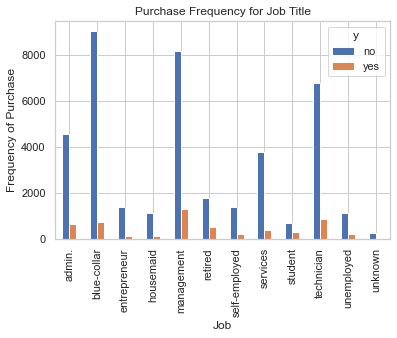

In [12]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

Text(0, 0.5, 'Proportion of Customers')

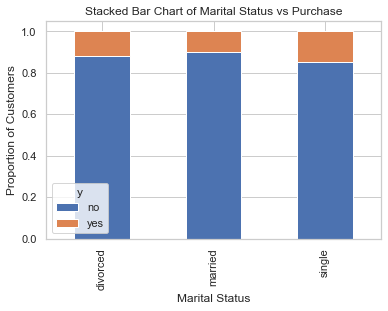

In [13]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

Hard to see, but the marital status does not seem a strong predictor for the outcome variable.

Text(0, 0.5, 'Proportion of Customers')

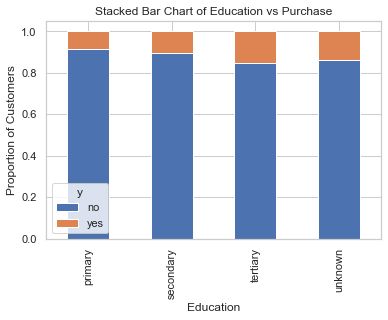

In [14]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')

Education seems a good predictor of the outcome variable.

Day of week may not be a good predictor of the outcome.

Text(0, 0.5, 'Frequency of Purchase')

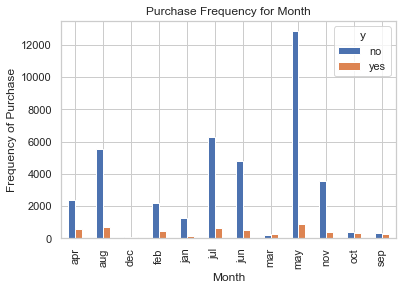

In [15]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')

Month might be a good predictor of the outcome variable.

Text(0, 0.5, 'Frequency')

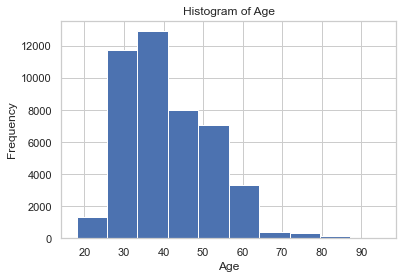

In [16]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

Most customers of the bank in this dataset are in the age range of 30-40.

Text(0, 0.5, 'Frequency of Purchase')

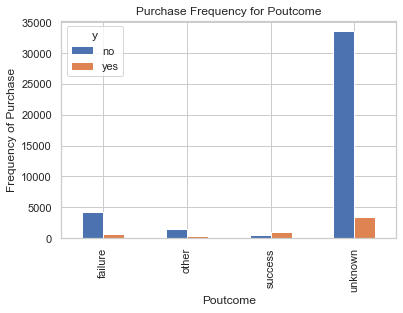

In [17]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')

Poutcome seems to be a good predictor of the outcome variable.

### Create dummy variables

In [18]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    #print(cat_list)
    data1=pd.merge(data, cat_list, left_index=True, right_index=True)
    data=data1
    
cat_vars=['job','marital','education','default','housing','loan','contact','month','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data[to_keep]
data_final.columns.values

array(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

#### Split The data  into Train-Test

In [19]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y'].replace({'yes': 1, 'no': 0})

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Over-sampling using SMOTE

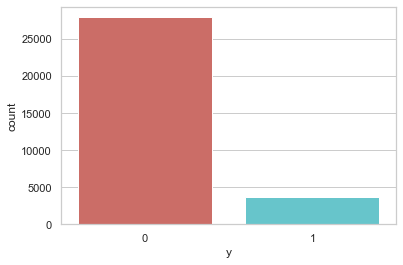

In [21]:
# before Oversampling
sns.countplot(x='y',data=y_train, palette='hls')
plt.show()

In [22]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))

length of oversampled data is  55906


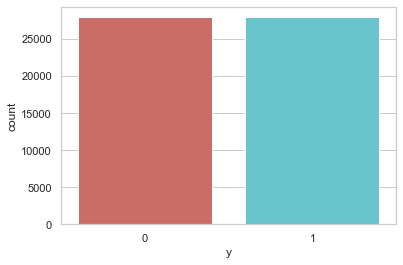

In [23]:
sns.countplot(x='y',data=os_data_y, palette='hls')
plt.show()

### Recursive feature elimination

In [24]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

In [25]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True False False  True  True False False False False False False
 False False False False False False False False False False False False
 False False False]
[26 32 27 30 24 31 28  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1
  1  1 23 29  1  1  7  6  5  4  3 17 12 19 15 11 14 18 22 16 13 20 21  9
 10 25  8]


The Recursive Feature Elimination (RFE) has helped us select the following features: "previous", "euribor3m", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_fri", "day_of_week_wed", "poutcome_failure", "poutcome_nonexistent", "poutcome_success".

In [26]:
cols=[ 'job_blue-collar', 'job_housemaid', 'default_no', 
      'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

### Implementing the model

In [27]:
import statsmodels.api as sm
logit_model=sm.Logit(y.astype(float),X.astype(float))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.387081
         Iterations 7
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.442     
Dependent Variable:  y                AIC:              43312.3152
Date:                2020-10-30 22:33 BIC:              43455.2180
No. Observations:    55906            Log-Likelihood:   -21640.   
Df Model:            15               LL-Null:          -38751.   
Df Residuals:        55890            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      7.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
job_blue-collar   -1.2060   0.0433 -27.8495 0.0000 -1.2909 -1.1211
job_housemaid     -1.7893   0.1403 -12.7581 0.0000 -2

The p-values for four variables are very high, therefore, we will remove them.

In [28]:
cols=['job_blue-collar', 'job_housemaid', 
      'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

In [29]:
logit_model=sm.Logit(y.astype(float),X.astype(float))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.531816
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.233     
Dependent Variable: y                AIC:              59489.3904
Date:               2020-10-30 22:33 BIC:              59605.4989
No. Observations:   55906            Log-Likelihood:   -29732.   
Df Model:           12               LL-Null:          -38751.   
Df Residuals:       55893            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
job_blue-collar  -0.6230   0.0376 -16.5692 0.0000 -0.6967 -0.5493
job_housemaid    -1.1965   0.1241  -9.6381 0.0000 -1.4398 -0.9532


### Logistic Regression Model Fitting

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [31]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


### Confusion Matrix

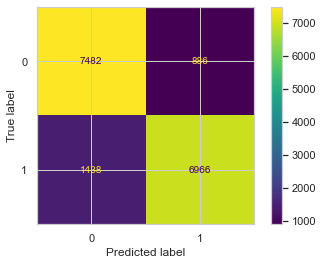

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(logreg, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      8368
           1       0.89      0.83      0.86      8404

    accuracy                           0.86     16772
   macro avg       0.86      0.86      0.86     16772
weighted avg       0.86      0.86      0.86     16772



#### Interpretation:

Of the entire test set, 74% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 74% of the customer's preferred term deposit were promoted.

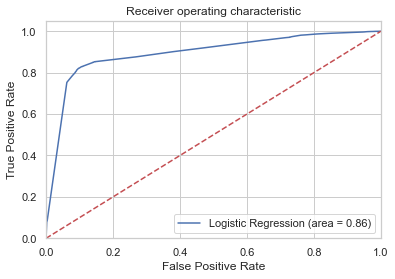

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()